In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Load the data
data = pd.read_csv('data_mmda_traffic_spatial.csv')

In [3]:
# 1. Data Preprocessing
# Convert Date and Time to datetime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')

In [4]:
# Handle missing values appropriately
data['City'].fillna('Unknown', inplace=True)
data['Direction'].fillna('Unknown', inplace=True)
data['Location'].fillna('Unknown', inplace=True)
data['Involved'].fillna('Unknown', inplace=True)
data['Type'].fillna('Unknown', inplace=True)

C:\Users\KOOPER\AppData\Local\Temp\ipykernel_4460\2807129619.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['City'].fillna('Unknown', inplace=True)
C:\Users\KOOPER\AppData\Local\Temp\ipykernel_4460\2807129619.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [5]:
# 2. Feature Engineering
# Extract time features
data['Hour'] = data['DateTime'].dt.hour
data['Minute'] = data['DateTime'].dt.minute
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
data['IsRushHour'] = (((data['Hour'] >= 7) & (data['Hour'] <= 9)) | 
                      ((data['Hour'] >= 16) & (data['Hour'] <= 19))).astype(int)
data['Month'] = data['DateTime'].dt.month
data['TimeOfDay'] = pd.cut(
    data['Hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

In [6]:
# Handle missing time-related features
# Fill Hour with median hour value
data['Hour'] = data['Hour'].fillna(data['Hour'].median())

# Fill Month with most frequent month
data['Month'] = data['Month'].fillna(data['Month'].mode()[0])

# Fill DayOfWeek with most frequent day
data['DayOfWeek'] = data['DayOfWeek'].fillna(data['DayOfWeek'].mode()[0])

# Recalculate dependent values that might be affected by the filled values
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
data['IsRushHour'] = (((data['Hour'] >= 7) & (data['Hour'] <= 9)) | 
                     ((data['Hour'] >= 16) & (data['Hour'] <= 19))).astype(int)

# Recalculate TimeOfDay based on filled Hour values
data['TimeOfDay'] = pd.cut(
    data['Hour'],
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

# Verify missing values have been handled
print("Time features missing values after handling:")
print(data[['Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'IsRushHour', 'TimeOfDay']].isna().sum())


Time features missing values after handling:
Hour            0
Month           0
DayOfWeek       0
IsWeekend       0
IsRushHour      0
TimeOfDay     247
dtype: int64


In [7]:
# First, verify that Hour values have all been filled properly
print(f"Missing Hour values: {data['Hour'].isna().sum()}")

Missing Hour values: 0


In [8]:
# Check for potentially invalid hour values 
print(f"Hours outside normal range: {len(data[(data['Hour'] < 0) | (data['Hour'] > 24)])}")

Hours outside normal range: 0


In [9]:
# Use a more robust approach to create TimeOfDay - handle edge cases better
data['TimeOfDay'] = pd.cut(
    data['Hour'].clip(0, 23.99),  # Clip to ensure all values are in range
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True  # Ensure boundary values are included
)

In [10]:
# Check remaining missing values after the fix
print(f"Missing TimeOfDay values after improvement: {data['TimeOfDay'].isna().sum()}")

Missing TimeOfDay values after improvement: 0


In [11]:
# Verify all missing values are fixed
print(f"Final TimeOfDay missing values: {data['TimeOfDay'].isna().sum()}")

Final TimeOfDay missing values: 0


In [12]:
# Create location clusters (spatial feature engineering)
# Only include rows with valid coordinates
valid_coords = data.dropna(subset=['Latitude', 'Longitude'])

In [13]:
# Create the clusters
kmeans = KMeans(n_clusters=10, random_state=42)
valid_coords['LocationCluster'] = kmeans.fit_predict(valid_coords[['Latitude', 'Longitude']])

In [14]:
# Map clusters back to original dataframe
data['LocationCluster'] = -1  # Default for missing coordinates
data.loc[valid_coords.index, 'LocationCluster'] = valid_coords['LocationCluster']

In [15]:
# 3. Target Preparation
# Create a simplified target by categorizing incident types
def simplify_incident_type(incident_type):
    incident_type = str(incident_type).upper()
    if 'ACCIDENT' in incident_type or 'COLLISION' in incident_type:
        return 'ACCIDENT'
    elif 'STALLED' in incident_type or 'MECHANICAL' in incident_type or 'BREAKDOWN' in incident_type:
        return 'VEHICLE_ISSUE'
    elif 'FIRE' in incident_type:
        return 'FIRE'
    elif 'FLOOD' in incident_type or 'WATER' in incident_type:
        return 'FLOOD'
    elif 'ROAD' in incident_type or 'CONSTRUCTION' in incident_type or 'WORK' in incident_type:
        return 'ROADWORK'
    else:
        return 'OTHER'


In [16]:
# Create simplified target variable
data['IncidentCategory'] = data['Type'].apply(simplify_incident_type)


In [17]:
# Display the distribution of incident categories
incident_counts = data['IncidentCategory'].value_counts()
print("Incident Category Distribution:")
print(incident_counts)

Incident Category Distribution:
IncidentCategory
ACCIDENT         12747
VEHICLE_ISSUE     3957
OTHER              381
ROADWORK           178
FIRE                36
FLOOD               13
Name: count, dtype: int64


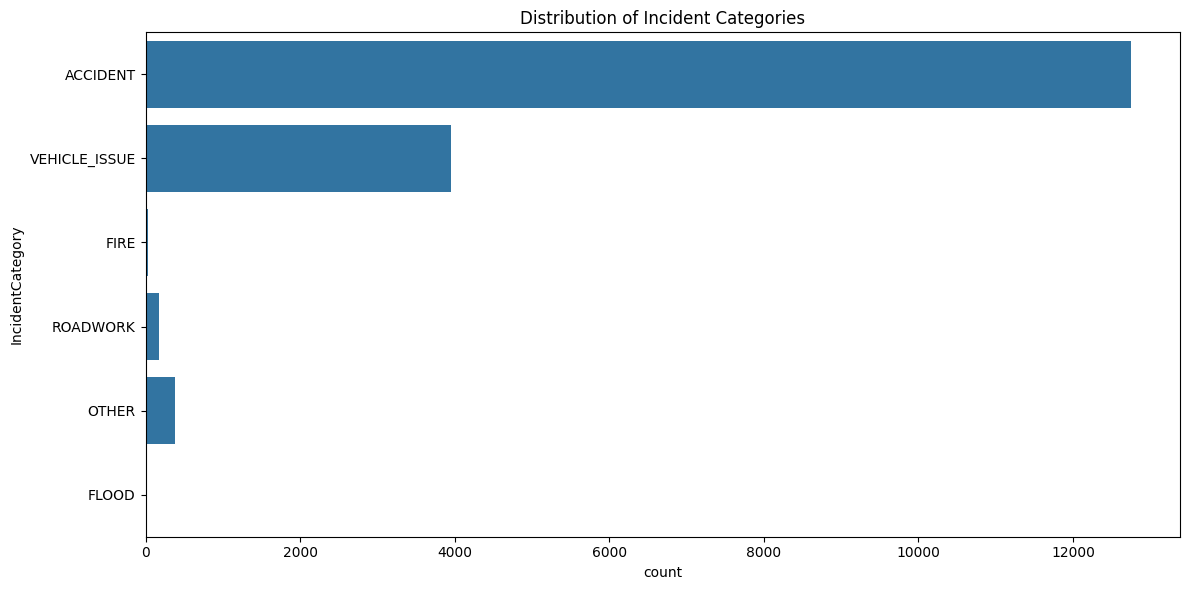

In [18]:
# Visualize incident distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='IncidentCategory', data=data)
plt.title('Distribution of Incident Categories')
plt.tight_layout()
plt.savefig('incident_distribution.png')

In [19]:
# 4. Feature Selection for Classification
# Select relevant features
categorical_features = ['City', 'Direction', 'TimeOfDay', 'IsWeekend', 'IsRushHour']
numeric_features = ['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 'LocationCluster']


In [20]:
# Encode categorical features
for col in categorical_features:
    if col in data.columns:
        data[col] = data[col].astype('category')


In [21]:
# Create dummy variables (one-hot encoding)
X = pd.get_dummies(data[categorical_features + numeric_features], drop_first=True)
y = data['IncidentCategory']

In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [23]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [24]:
# 5. Train Multiple Classification Models
models = {
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }
    print(f"{name} Accuracy: {accuracy:.4f}")


Training Naive Bayes...
Naive Bayes Accuracy: 0.0090
Training Random Forest...
Random Forest Accuracy: 0.7115
Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7407


In [25]:
# 6. Detailed Evaluation of Best Model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = models[best_model_name]
best_accuracy = results[best_model_name]['accuracy']

print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")


Best Model: Gradient Boosting with accuracy 0.7407


In [26]:
# Generate detailed classification report
y_pred = results[best_model_name]['predictions']
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

     ACCIDENT       0.74      0.99      0.85      2550
         FIRE       0.00      0.00      0.00         7
        FLOOD       0.00      0.00      0.00         3
        OTHER       0.61      0.14      0.23        76
     ROADWORK       1.00      0.03      0.05        36
VEHICLE_ISSUE       0.52      0.03      0.06       791

     accuracy                           0.74      3463
    macro avg       0.48      0.20      0.20      3463
 weighted avg       0.69      0.74      0.64      3463



c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

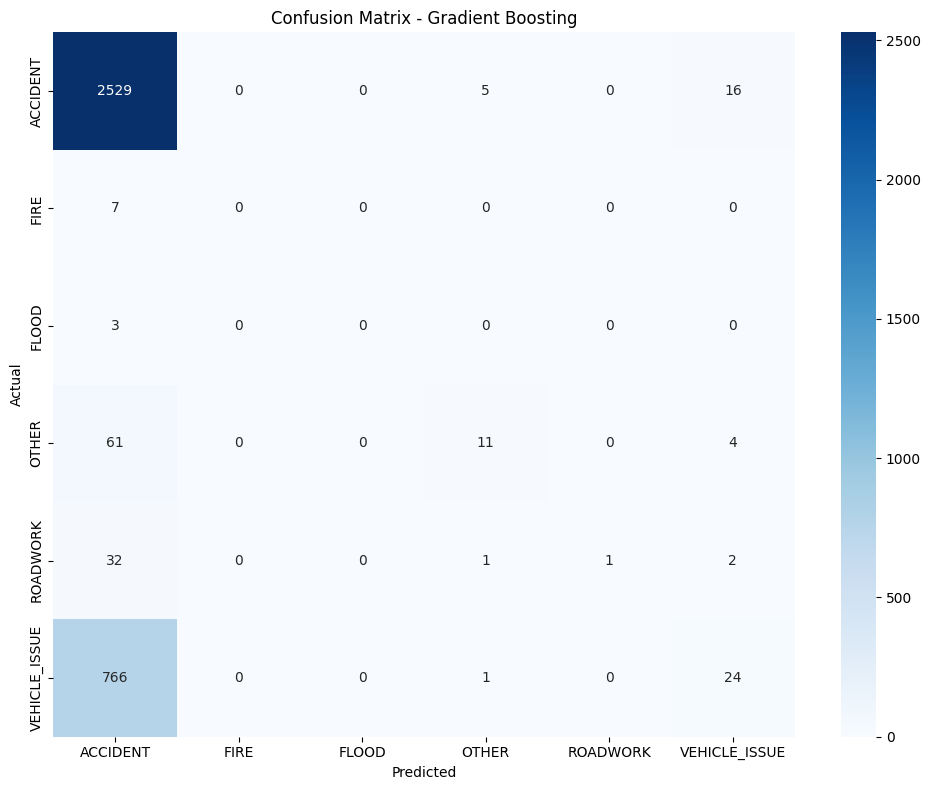

In [27]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

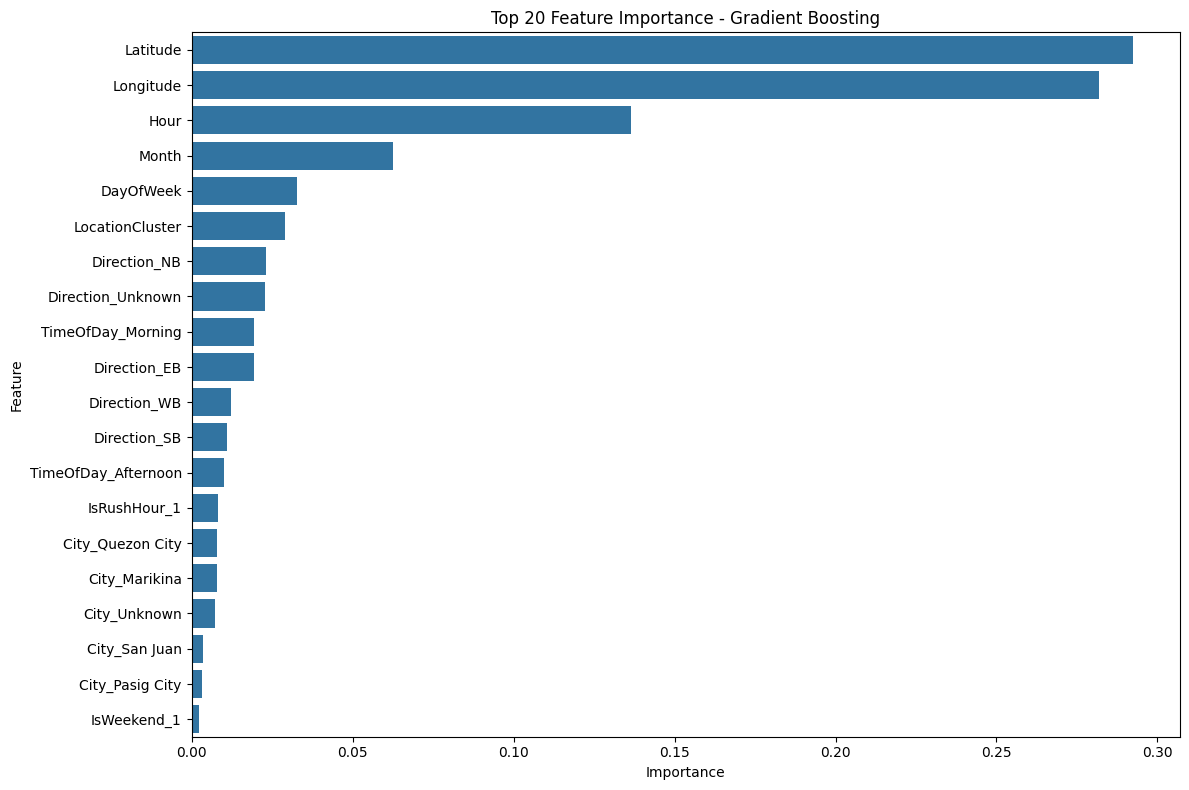

In [28]:
# 7. Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('classification_feature_importance.png')


In [29]:
# 8. Cross-Validation for Robust Evaluation
print("\nPerforming cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y_encoded, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name} - Mean CV Accuracy: {scores.mean():.4f}, Std: {scores.std():.4f}")



Performing cross-validation...
Naive Bayes - Mean CV Accuracy: 0.0084, Std: 0.0013
Random Forest - Mean CV Accuracy: 0.7151, Std: 0.0039
Gradient Boosting - Mean CV Accuracy: 0.7397, Std: 0.0022


In [30]:
# 9. Create a Model to Predict Location and Time-based Incidents
# This answers "what incident is likely to occur at this time and location?"

# Function to predict incident type given location and time
def predict_incident(latitude, longitude, hour, day_of_week, is_weekend, is_rush_hour, city):
    # Create a data point with the given features
    input_data = pd.DataFrame({
        'Latitude': [latitude],
        'Longitude': [longitude],
        'Hour': [hour],
        'DayOfWeek': [day_of_week],
        'IsWeekend': [is_weekend],
        'IsRushHour': [is_rush_hour],
        'City': [city]
    })
    
    # Determine location cluster
    input_data['LocationCluster'] = kmeans.predict(input_data[['Latitude', 'Longitude']])
    
    # Create time of day
    if 0 <= hour < 6:
        time_of_day = 'Night'
    elif 6 <= hour < 12:
        time_of_day = 'Morning'
    elif 12 <= hour < 18:
        time_of_day = 'Afternoon'
    else:
        time_of_day = 'Evening'
    
    input_data['TimeOfDay'] = time_of_day
    
    # Add month (you can adjust this)
    input_data['Month'] = 1  # Default to January
    
    # Determine direction (if needed)
    input_data['Direction'] = 'Unknown'  # Default
    
    # One-hot encode the features
    input_encoded = pd.get_dummies(input_data[categorical_features + numeric_features])
    
    # Make sure all columns match the training columns
    for col in X.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    # Reorder columns to match training data
    input_encoded = input_encoded[X.columns]
    
    # Predict incident type
    prediction = best_model.predict(input_encoded)
    predicted_class = label_encoder.inverse_transform(prediction)[0]
    
    # Get probabilities for all classes
    if hasattr(best_model, 'predict_proba'):
        probs = best_model.predict_proba(input_encoded)[0]
        class_probs = {label_encoder.classes_[i]: probs[i] for i in range(len(probs))}
        return predicted_class, class_probs
    else:
        return predicted_class, None


In [31]:
# Example usage
test_location = (14.59, 121.05)  # Example coordinates
test_time = 8  # 8 AM
test_day = 0  # Monday
test_weekend = 0  # Not weekend
test_rush = 1  # Rush hour
test_city = 'Pasig City'

predicted_incident, probabilities = predict_incident(
    test_location[0], test_location[1], test_time, test_day, test_weekend, test_rush, test_city
)

print("\nPrediction Example:")
print(f"Location: {test_location}, Time: {test_time}:00, Day: Monday, Rush hour: Yes")
print(f"Predicted incident type: {predicted_incident}")

if probabilities:
    print("Probabilities for each incident type:")
    for incident, prob in probabilities.items():
        print(f"  {incident}: {prob:.4f}")



Prediction Example:
Location: (14.59, 121.05), Time: 8:00, Day: Monday, Rush hour: Yes
Predicted incident type: ACCIDENT
Probabilities for each incident type:
  ACCIDENT: 0.4539
  FIRE: 0.0041
  FLOOD: 0.0006
  OTHER: 0.3303
  ROADWORK: 0.0029
  VEHICLE_ISSUE: 0.2082



Classification analysis complete. Files generated for research paper.


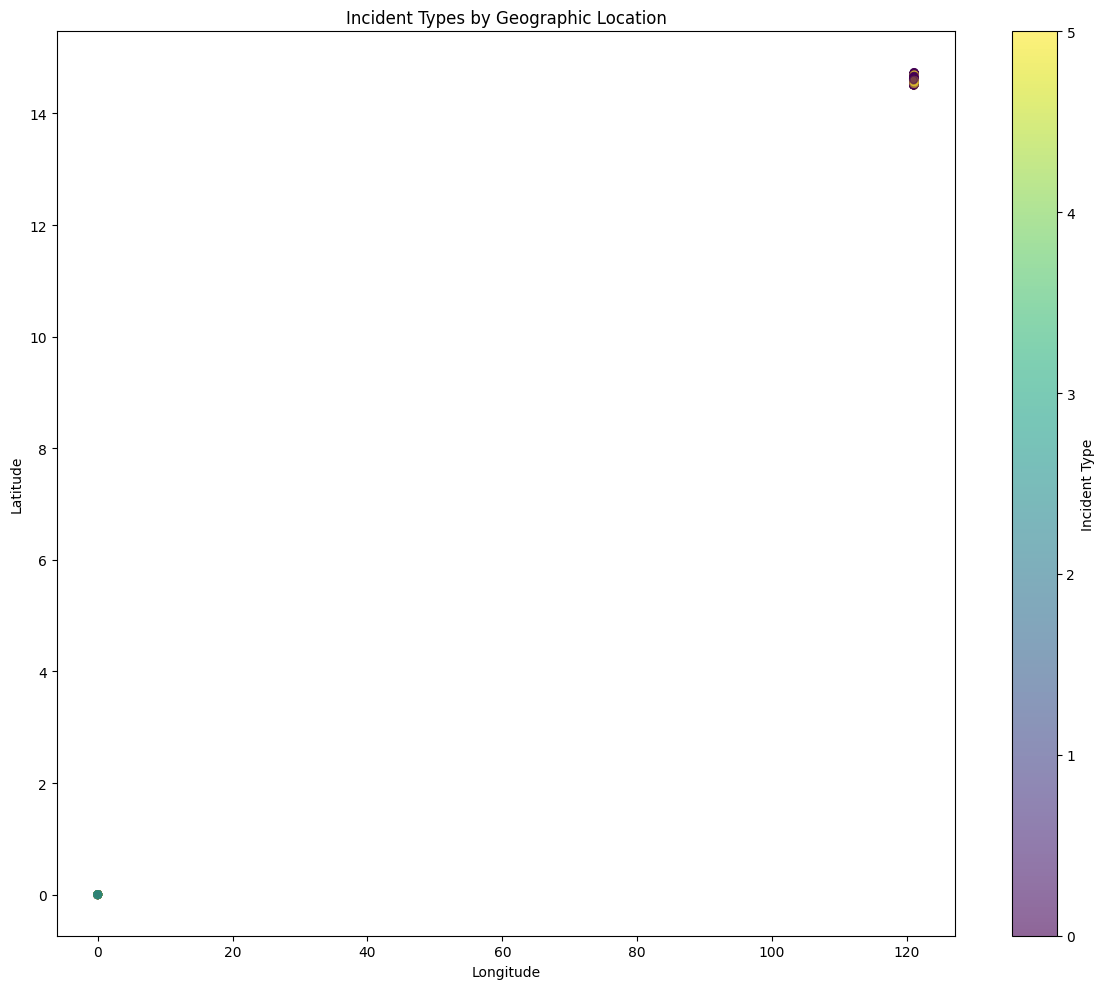

In [32]:
# 10. Visualize Incident Types by Location for Research Paper
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    data['Longitude'], 
    data['Latitude'], 
    c=label_encoder.transform(data['IncidentCategory']), 
    cmap='viridis', 
    alpha=0.6, 
    s=30
)
plt.colorbar(scatter, label='Incident Type')
plt.title('Incident Types by Geographic Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('incident_map.png')

print("\nClassification analysis complete. Files generated for research paper.")

In [33]:
# Save the trained models for production use
import joblib

# Save the best model
joblib.dump(best_model, 'traffic_incident_model.pkl')

# Save the KMeans model for location clustering
joblib.dump(kmeans, 'location_cluster_model.pkl')

# Save the label encoder for decoding predictions
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the feature column names to ensure consistency
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

# Save the categorical and numeric feature lists
model_config = {
    'categorical_features': categorical_features,
    'numeric_features': numeric_features
}
joblib.dump(model_config, 'model_config.pkl')

print("Models saved successfully for production deployment.")

Models saved successfully for production deployment.


In [34]:
# Correlation analysis between numerical features
numeric_data = data[['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 
                     'IsWeekend', 'IsRushHour', 'LocationCluster']]
correlation_matrix = numeric_data.corr()


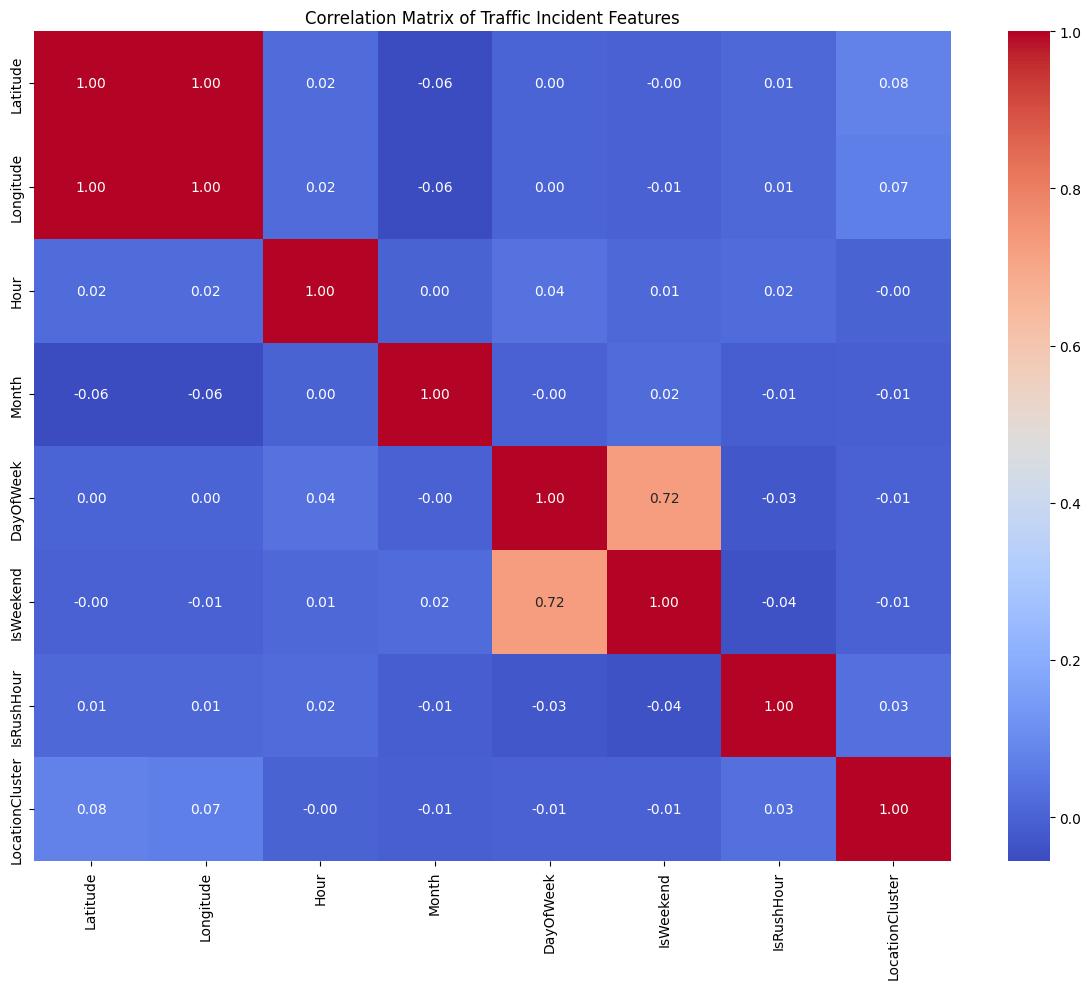

In [35]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Traffic Incident Features')
plt.tight_layout()
plt.savefig('correlation_analysis.png')

# Creating an Interactive Web Interface

After developing our traffic incident prediction model, we need to create a user-friendly interface. We've developed two versions:

1. A basic interface with manual coordinate input (`templates/index.html`)
2. An enhanced interface with a location dropdown and interactive map (`templates/index_2.html`)

The enhanced interface uses Leaflet.js to display an interactive map where users can:
- Select predefined locations from a dropdown
- Click directly on the map to set custom coordinates
- See prediction results alongside the map

To use the enhanced interface, modify the Flask app route as follows:

c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KOOPER\Desktop\Final_Model_Website\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr


Naive Bayes Performance Metrics:
        Class  Precision  Recall  F1-Score
     ACCIDENT     0.6667  0.0016    0.0031
         FIRE     0.0012  0.2857    0.0025
        FLOOD     0.0015  0.6667    0.0030
        OTHER     0.1127  0.1053    0.1088
     ROADWORK     0.0286  0.3611    0.0530
VEHICLE_ISSUE     0.2500  0.0025    0.0050
Macro Average     0.1768  0.2371    0.0292

Random Forest Performance Metrics:
        Class  Precision  Recall  F1-Score
     ACCIDENT     0.7571  0.9047    0.8244
         FIRE     1.0000  0.1429    0.2500
        FLOOD     0.0000  0.0000    0.0000
        OTHER     0.5714  0.2632    0.3604
     ROADWORK     0.2222  0.0556    0.0889
VEHICLE_ISSUE     0.3622  0.1694    0.2308
Macro Average     0.4855  0.2559    0.2924

Gradient Boosting Performance Metrics:
        Class  Precision  Recall  F1-Score
     ACCIDENT     0.7443  0.9918    0.8504
         FIRE     0.0000  0.0000    0.0000
        FLOOD     0.0000  0.0000    0.0000
        OTHER     0.6111  0.14

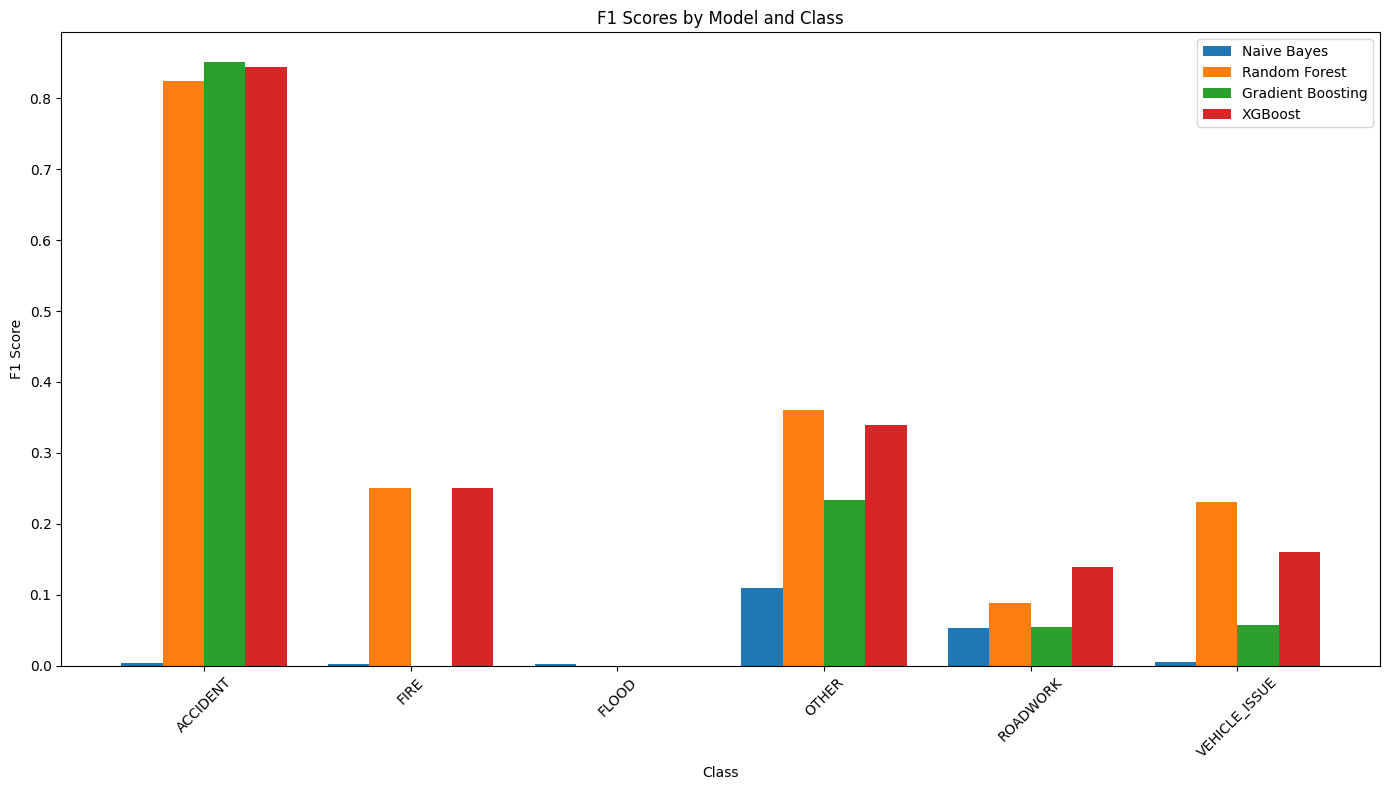

In [36]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt

# Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Get predictions for all models
models_to_evaluate = {
    'Naive Bayes': models['Naive Bayes'],
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting'],
    'XGBoost': xgb_model
}

# Function to calculate metrics for each model
def calculate_metrics(model_name, y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Calculate macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    
    # Create DataFrame with metrics for each class
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    # Add macro average row
    metrics_df.loc[len(metrics_df)] = ['Macro Average', macro_precision, macro_recall, macro_f1]
    
    return metrics_df

# Calculate metrics for each model
all_metrics = {}
for name, model in models_to_evaluate.items():
    if name == 'XGBoost':
        pred = xgb_pred
    else:
        pred = results[name]['predictions']
    
    all_metrics[name] = calculate_metrics(name, y_test, pred)

# Display metrics for each model
for name, metrics_df in all_metrics.items():
    print(f"\n{name} Performance Metrics:")
    print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Create bar plots comparing F1 scores across models
plt.figure(figsize=(14, 8))
bar_width = 0.2
x = np.arange(len(class_names))

for i, (name, metrics_df) in enumerate(all_metrics.items()):
    # Plot F1 scores for each class (excluding the macro average row)
    plt.bar(x + i*bar_width, metrics_df['F1-Score'][:-1], width=bar_width, label=name)

plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Model and Class')
plt.xticks(x + bar_width*1.5, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison_f1.png')
plt.show()